In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import statsmodels.api as sm

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing the training set
file_name = '/Users/z063638/Downloads/Recurrent_Neural_Networks/Metro_Interstate_Traffic_Volume.csv'
metro_traffic = pd.read_csv(file_name, parse_dates=True, index_col='date_time')

In [4]:
metro_traffic = metro_traffic.loc[~metro_traffic.index.duplicated(keep='first')] 
metro_traffic = metro_traffic.asfreq('H') 

In [5]:
metro_traffic.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=52551, freq='H')

In [6]:
metro_traffic.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.316763,0.318632,0.000117,44.199162,3290.650474
std,13.816618,48.812640,0.005676,38.683447,1984.772909
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.840000,0.000000,0.000000,1.000000,1248.500000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
#Missing records during winter & start of Spring only for Year 2015  
(metro_traffic['2015-01-01' : '2015-06-10'])[45:80].head(5) 

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2015-01-02 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


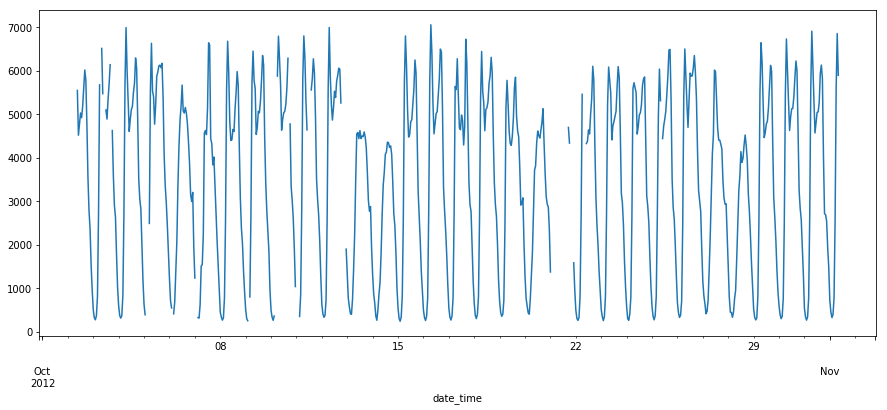

In [8]:
metro_traffic['traffic_volume'][:720].plot(figsize=(15,6))

In [9]:
sum(metro_traffic['traffic_volume'].isna())

11976

In [10]:
 len(metro_traffic) /sum(metro_traffic['traffic_volume'].isna())

4.388026052104208

In [11]:
metro_traffic['traffic_volume'] = metro_traffic['traffic_volume'].fillna(metro_traffic['traffic_volume'].mean())

In [12]:
sum(metro_traffic['traffic_volume'].isna())

0

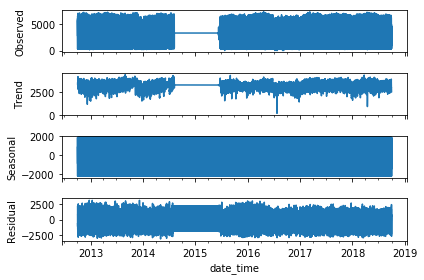

In [13]:

result = seasonal_decompose(metro_traffic['traffic_volume'], model='add', freq= 24)  #Lets try with Add model first
result.plot();

In [14]:
metro_traffic[metro_traffic['traffic_volume'] <=0].index  

DatetimeIndex(['2016-07-23 18:00:00', '2016-07-23 23:00:00'], dtype='datetime64[ns]', name='date_time', freq='5H')

In [15]:
#Lets filter a month/two  records and decompose it to unserstand the unserlaying patteren

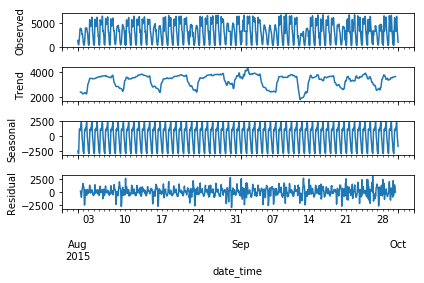

In [16]:
metro_traffic_decompose = seasonal_decompose(metro_traffic['traffic_volume']['2015-08-01': '2015-09-30'], model='add', freq= 24);#Lets try with Add model first
metro_traffic_decompose.plot();

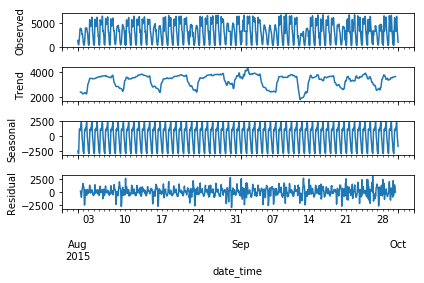

In [17]:
seasonal_decompose(metro_traffic['traffic_volume']['2015-08-01': '2015-09-30'], model='MULTIPLICATIVE', freq= 24).plot();  #Lets try with Add model first


# Tests for Stationarity - 

# Approach 1 - Dickey-Fuller Test

In [18]:
#To determine whether a series is stationary we can use the augmented Dickey-Fuller Test. 
#In this test the null hypothesis states that  𝜙=1  (this is also called a unit test). 
#The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ( 𝑝<0.05 ) 
#indicates strong evidence against the null hypothesis.

#To demonstrate, we'll use a dataset we know is not stationary, the airline_passenger dataset. First, 
#let's plot the data along with a 12-month rolling mean and standard deviation:

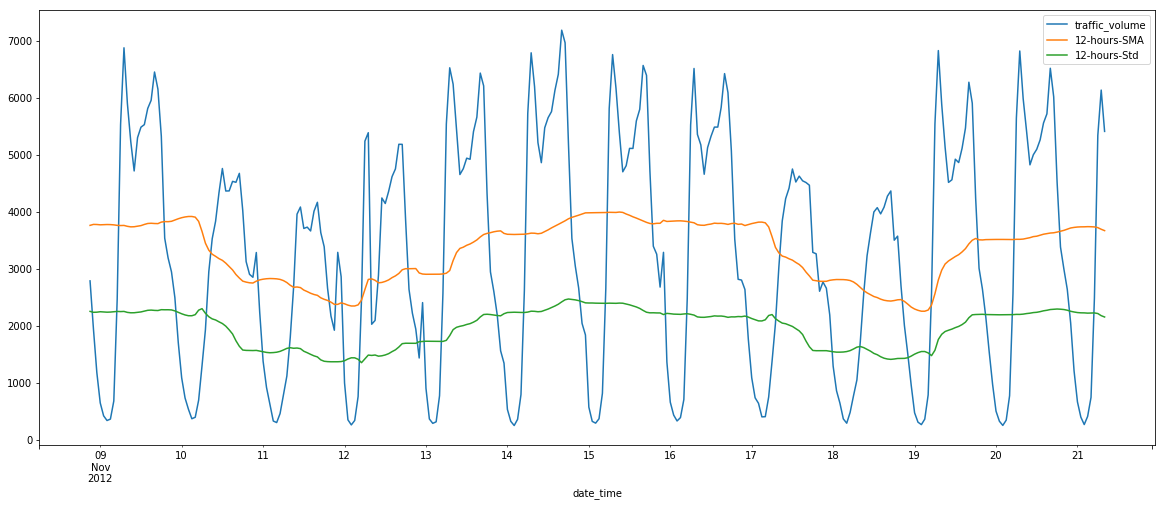

In [19]:
metro_traffic['12-hours-SMA'] = metro_traffic['traffic_volume'].rolling(window=24).mean()
metro_traffic['12-hours-Std'] = metro_traffic['traffic_volume'].rolling(window=24).std()

metro_traffic[['traffic_volume','12-hours-SMA','12-hours-Std']][900:1200].plot(figsize= (20,8));

In [20]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and hence it is a stationary data")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [21]:
adf_test(metro_traffic['traffic_volume'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -33.915980
p-value                     0.000000
# lags used                57.000000
# observations          52493.000000
critical value (1%)        -3.430475
critical value (5%)        -2.861595
critical value (10%)       -2.566799
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and hence it is a stationary data


In [22]:
#Data has no unit root and hence data is stationary

# ACF and PACF

  ## Autocorrelation Function / Partial Autocorrelation Function

In [23]:
# Import the models we'll be using in this section
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [24]:
acf(metro_traffic['traffic_volume'])

array([ 1.        ,  0.85343633,  0.69228479,  0.48319039,  0.30162144,
        0.13099493, -0.0311911 , -0.16437853, -0.27114348, -0.35610878,
       -0.44799762, -0.53354758, -0.58072973, -0.54543597, -0.46941658,
       -0.37933954, -0.29355511, -0.18907713, -0.05826614,  0.09543885,
        0.25525347,  0.42167169,  0.59561469,  0.74039126,  0.81512419,
        0.74982312,  0.60883061,  0.44093882,  0.27733334,  0.12266669,
       -0.03006156, -0.16631361, -0.27723899, -0.37251408, -0.46511577,
       -0.54851487, -0.59080525, -0.56016413, -0.48467715, -0.39528599,
       -0.30319413])

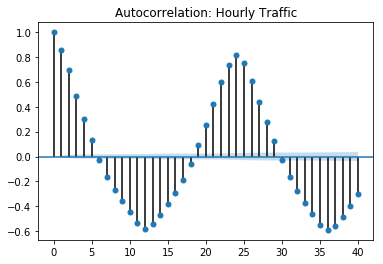

In [25]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Hourly Traffic'
lags = 40
plot_acf(metro_traffic['traffic_volume'],title=title,lags=lags);

In [26]:
# This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on 
# the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component 
# in the ARIMA model. However looks like this in the above graph/data AR componenet is present. 

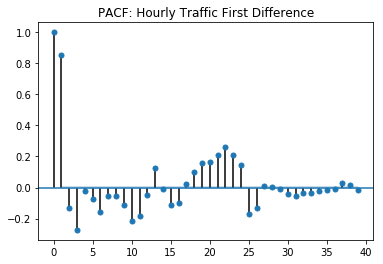

In [27]:
# Partial autocorrelations work best with stationary data. 

title='PACF: Hourly Traffic First Difference'
lags=40
plot_pacf(metro_traffic['traffic_volume'].dropna(),title=title,lags=np.arange(lags)); 

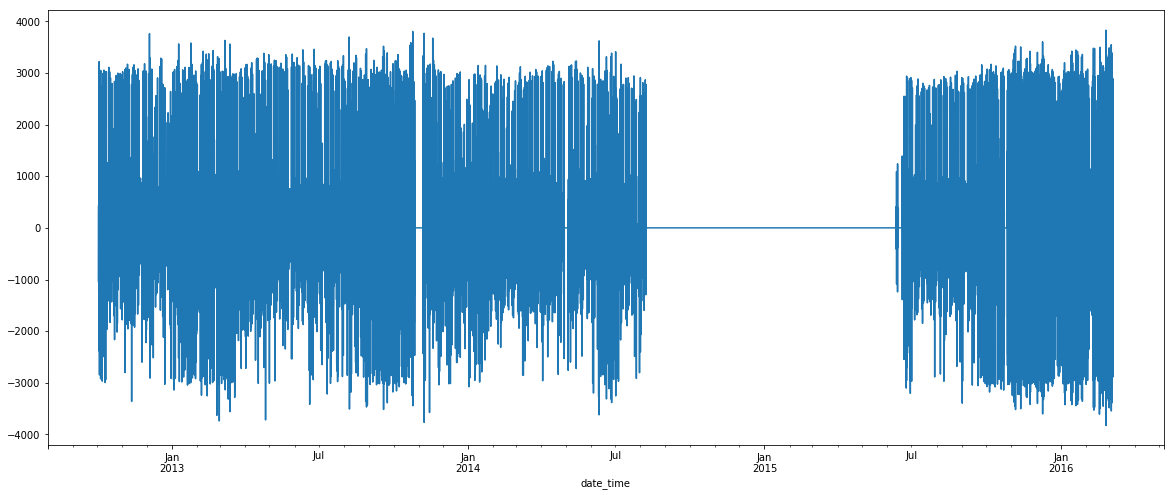

In [28]:
from statsmodels.tsa.statespace.tools import diff

#filtered_metro_trafic.reindex()

#filtered_metro_trafic[filtered_metro_trafic.index.duplicated()]
diff(metro_traffic['traffic_volume'],k_diff=1)[0:30000].plot.line(figsize=(20,8)) #Displaying first 30000 hours PACF 


In [29]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
#day(filtered_metro_trafic['traffic_volume'])
metro_traffic_quarter = metro_traffic['traffic_volume'].resample(rule='Q').mean()
metro_traffic_month = metro_traffic['traffic_volume'].resample(rule='M').mean()


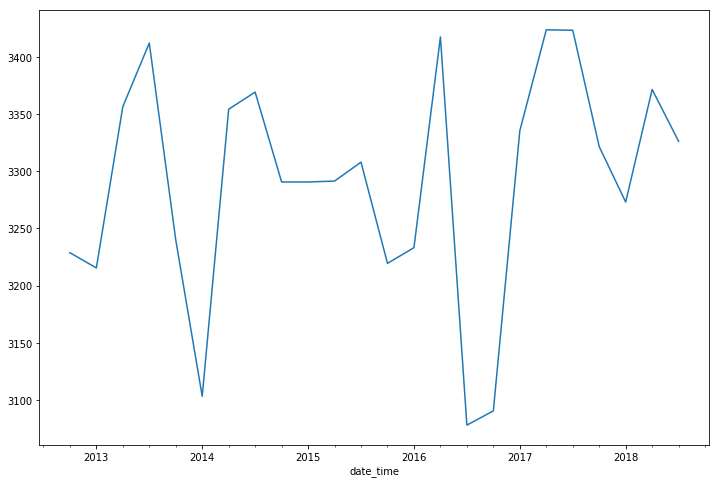

In [30]:
metro_traffic_quarter.plot(figsize=(12,8))

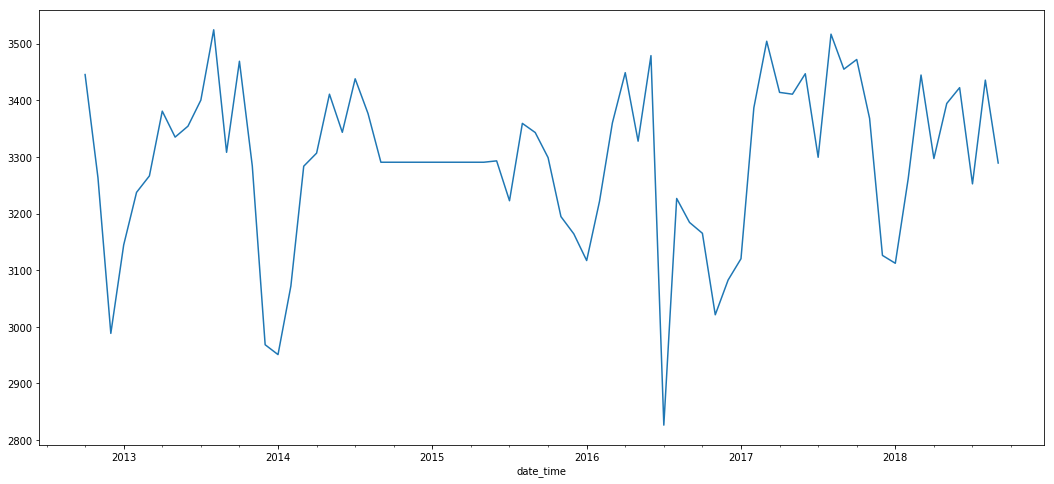

In [31]:
metro_traffic_month.plot(figsize=(18,8))

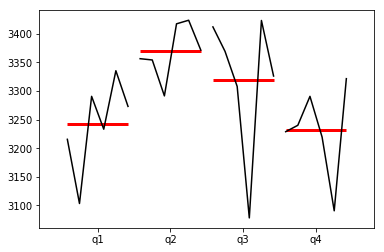

In [32]:
quarter_plot(metro_traffic_quarter);

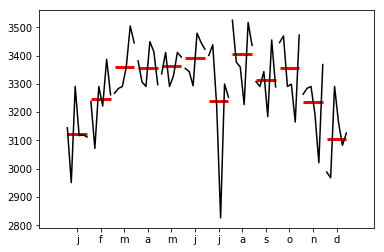

In [33]:
month_plot(metro_traffic_month);

In [34]:
# One year records will be used for the t
number_of_days = 365 * 24
number_of_days

8760

In [35]:
total_number_of_records = len(metro_traffic['traffic_volume']) 
total_number_of_records

52551

In [36]:
training_traffic_df = metro_traffic[:total_number_of_records-number_of_days]
testing_traffic_df = metro_traffic[-(number_of_days):]

In [37]:
len(testing_traffic_df)+ len(training_traffic_df)

52551

In [38]:
stepwise_fit = auto_arima(metro_traffic['traffic_volume'], start_p=0, start_q=0,
                           max_p=10, 
                           max_q=10, m=24,
                           seasonal=False,
                           d=None, 
                           trace=True,
                           error_action='ignore',   # we don't want to know if an order does not work
                           suppress_warnings=True,  # we don't want convergence warnings
                           stepwise=True)           # set to stepwise

Fit ARIMA: order=(0, 0, 0); AIC=933611.401, BIC=933629.140, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0); AIC=865118.112, BIC=865144.720, Fit time=0.107 seconds
Fit ARIMA: order=(0, 0, 1); AIC=897278.467, BIC=897305.075, Fit time=0.121 seconds
Fit ARIMA: order=(2, 0, 0); AIC=864184.456, BIC=864219.934, Fit time=3.120 seconds
Fit ARIMA: order=(2, 0, 1); AIC=858794.698, BIC=858839.046, Fit time=13.261 seconds
Fit ARIMA: order=(3, 0, 2); AIC=857711.254, BIC=857773.341, Fit time=16.420 seconds
Fit ARIMA: order=(2, 0, 2); AIC=858373.594, BIC=858426.812, Fit time=15.708 seconds
Fit ARIMA: order=(4, 0, 2); AIC=857515.781, BIC=857586.737, Fit time=19.679 seconds
Fit ARIMA: order=(4, 0, 1); AIC=857771.121, BIC=857833.207, Fit time=19.238 seconds
Fit ARIMA: order=(4, 0, 3); AIC=857085.420, BIC=857165.246, Fit time=20.528 seconds
Fit ARIMA: order=(5, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 3); AIC=857375.022, BIC=857445.978, Fit time=20.615 seconds
Fit ARIMA: or

In [39]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                52551
Model:                     ARMA(7, 2)   Log Likelihood             -424602.244
Method:                       css-mle   S.D. of innovations            781.187
Date:                Thu, 22 Aug 2019   AIC                         849226.489
Time:                        11:08:11   BIC                         849324.054
Sample:                             0   HQIC                        849256.980
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3290.6499      8.227    400.004      0.000    3274.526    3306.774
ar.L1.y        2.6389      0.001   2862.405      0.000       2.637       2.641
ar.L2.y       -2.2656      0.001  -3304.536      0.000      -2.267      -2.264
ar.L3.y        0.2601        nan        nan        nan         nan         nan
ar.L4.y        0.5949      0.000   2271.068      0.000       0.594       0.595
ar.L5.y       -0.2502      0.001   -291.015      0.000      -0.252      -0.249
ar.L6.y       -0.0205      0.002     -8.303      0.000      -0.025      -0.016
ar.L7.y        0.0134      0.002      6.220      0.000       0.009       0.018
ma.L1.y       -1.9177      0.001  -1582.900      0.000      -1.920      -1.915
ma.L2.y        0.9879      0.001   1066.572      0.000       0.986       0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9661           -0.2589j            1.0002           -0.0417
AR.2            0.9661           +0.2589j            1.0002            0.0417
AR.3            1.2457           -0.8184j            1.4905           -0.0925
AR.4            1.2457           +0.8184j            1.4905            0.0925
AR.5           -2.1696           -0.0000j            2.1696           -0.5000
AR.6           -4.3153           -0.0000j            4.3153           -0.5000
AR.7            3.5896           -0.0000j            3.5896           -0.0000
MA.1            0.9706           -0.2649j            1.0061           -0.0424
MA.2            0.9706           +0.2649j            1.0061            0.0424
-----------------------------------------------------------------------------
"""

# Fit an ARMA(p,q) Model

In [40]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults

model = ARMA(training_traffic_df['traffic_volume'],order=(7,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                43791
Model:                     ARMA(7, 2)   Log Likelihood             -354940.897
Method:                       css-mle   S.D. of innovations            801.380
Date:                Thu, 22 Aug 2019   AIC                         709903.793
Time:                        11:14:34   BIC                         709999.353
Sample:                    10-02-2012   HQIC                        709933.912
                         - 09-30-2017                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3284.1296      8.875    370.053      0.000    3266.735    3301.524
ar.L1.traffic_volume     2.5810      0.001   2965.231      0.000       2.579       2.583
ar.L2.traffic_volume    -2.1124      0.001  -2029.085      0.000      -2.114      -2.110
ar.L3.traffic_volume     0.1378        nan        nan        nan         nan         nan
ar.L4.traffic_volume     0.5836      0.000   2026.767      0.000       0.583       0.584
ar.L5.traffic_volume    -0.1857      0.002    -97.917      0.000      -0.189      -0.182
ar.L6.traffic_volume    -0.0534      0.003    -16.852      0.000      -0.060      -0.047
ar.L7.traffic_volume     0.0189      0.002      9.496      0.000       0.015       0.023
ma.L1.traffic_volume    -1.9172      0.001  -1664.228      0.000      -1.919      -1.915
ma.L2.traffic_volume     0.9874      0.001   1096.179      0.000       0.986       0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9661           -0.2589j            1.0002           -0.0417
AR.2            0.9661           +0.2589j            1.0002            0.0417
AR.3            1.2618           -0.8243j            1.5072           -0.0921
AR.4            1.2618           +0.8243j            1.5072            0.0921
AR.5           -2.5376           -0.5642j            2.5996           -0.4652
AR.6           -2.5376           +0.5642j            2.5996            0.4652
AR.7            3.4521           -0.0000j            3.4521           -0.0000
MA.1            0.9709           -0.2650j            1.0064           -0.0424
MA.2            0.9709           +0.2650j            1.0064            0.0424
-----------------------------------------------------------------------------
"""

In [42]:

start=len(training_traffic_df)
end=len(training_traffic_df)+len(testing_traffic_df)-1

predictions = results.predict(start=start, end=end).rename('ARMA(7,2) Predictions')

In [43]:
deleteme = testing_traffic_df
deleteme['predictions'] = predictions

In [44]:
deleteme[['traffic_volume','predictions']].mean()

traffic_volume    3323.245041
predictions       3283.720789
dtype: float64

In [45]:
deleteme[['traffic_volume','predictions']].tail(10)

,traffic_volume,predictions
date_time,,
2018-09-30 14:00:00,4380.0,3582.745827
2018-09-30 15:00:00,4302.0,3523.665544
2018-09-30 16:00:00,4283.0,3448.284489
2018-09-30 17:00:00,4132.0,3361.747361
2018-09-30 18:00:00,3947.0,3269.957020
2018-09-30 19:00:00,3543.0,3179.171849
2018-09-30 20:00:00,2781.0,3095.579046
2018-09-30 21:00:00,2159.0,3024.872959
2018-09-30 22:00:00,1450.0,2971.867184


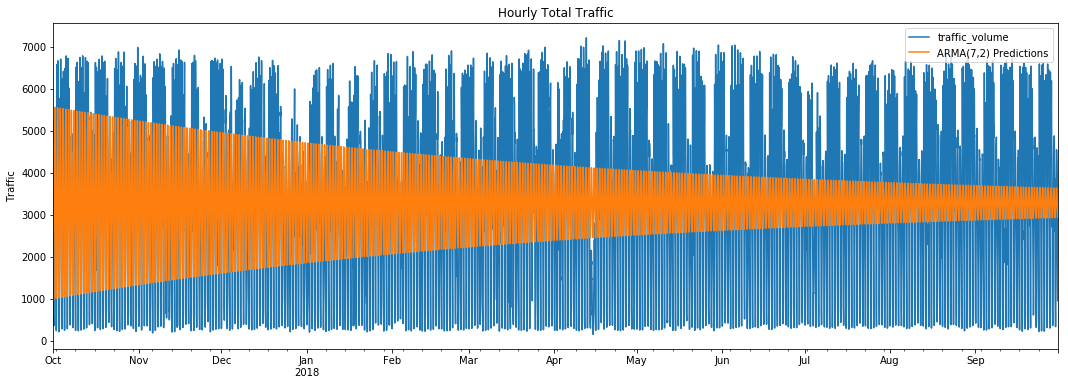

In [46]:
title = 'Hourly Total Traffic'
ylabel='Traffic'
xlabel='' # we don't really need a label here

ax = testing_traffic_df['traffic_volume'].plot(legend=True,figsize=(18,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [49]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(testing_traffic_df['traffic_volume'], predictions)
print(f'ARMA(7,2) MSE Error: {error:11.10}')


ARMA(7,2) MSE Error: 2261100.621


In [54]:
training_traffic_df['traffic_volume'].mean() *training_traffic_df['traffic_volume'].mean()

10785511.310158491

In [55]:
from statsmodels.tools.eval_measures import rmse

error = rmse(testing_traffic_df['traffic_volume'], predictions)
print(f'ARMA(7,2) RMSE Error: {error:11.10}')

ARMA(7,2) RMSE Error: 1503.695654
